In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
eSpread = 2.0e-3
NL_t = 0.4
CLcut = 2.6


emitGeomRMS = 3.3e-6
npt = 1000000
print('npt=',npt)
nturn = 1

npt= 1000000


In [3]:
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

# read Aperture

In [4]:
aperture = np.loadtxt('../pipeinfo.in')

# read impact lattice

In [5]:
beam,lattice = impact.readInputFile('../test.Chad.in')
beam.nCore_y=2
beam.nCore_z=5
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg

reading ImpactZ input file (../test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [6]:
cleanLat = impact.clearLattice(lattice)
L = 0 
for item in cleanLat:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        print('NL:',L,L+item.length)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [7]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

# Back tracking for IOTA matched beam at injection location

In [8]:
for i in range(len(cleanLat)):
    if cleanLat[i].type == 'nonlinear_insert':
        break

latticeB = impact.getInverseLattice(cleanLat[:i])

In [9]:
write10 = impact.getElem('write_raw_ptcl')
write10.file_id = 111110
write10.format_id = 2
latticeB.insert(0,write10)

write20 = impact.getElem('write_raw_ptcl')
write20.file_id = 222220
write20.format_id = 1
latticeB.insert(0,write20)


write11 = impact.getElem('write_raw_ptcl')
write11.file_id = 111111
write11.format_id = 2
latticeB.append(write11)

write21 = impact.getElem('write_raw_ptcl')
write21.file_id = 222221
write21.format_id = 1
latticeB.append(write21)

In [10]:
loop = impact.getElem('loop')
loop.turns = 1
latticeB.insert(0,loop)

In [11]:
beam.distribution.distribution_type = 'IOTA_Gauss'
beam.distribution.NL_t  = NL_t
beam.distribution.NL_c  = NL_c
beam.distribution.betx  = betx
beam.distribution.alfx  = alfx
beam.distribution.emitx = emitGeomRMS
beam.distribution.CL    = CLcut
beam.distribution.betz  = 200
beam.distribution.alfz  = 0.0
beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz
betx,alfx,emitGeomRMS,beam.distribution.emitz

(1.8926320036288808, 1.3763819204711734, 3.3e-06, 0.005)

In [12]:
write99 = impact.getElem('write_raw_ptcl')
write99.file_id = 99999
write99.format_id = 2

impact.writeInputFile(beam,[loop,write99])
impact.run(beam,order=1)

0

In [13]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = write99.file_id

In [14]:
impact.writeInputFile(beam,latticeB)
impact.run(beam,order=1)

0

In [15]:
pData0 = impact.readParticleData(111110,ke,mass,freq,2)
pData00 = impact.readParticleData(222220,ke,mass,freq,1)

In [16]:
impact.getTwiss_from_pData(pData0)

(1.4744999101517509,
 1.0727487269746432,
 1.7467696725342352e-06,
 3.395681888775853,
 2.469621994503095,
 4.016027456845636e-06,
 199.69543155456577,
 0.0003189166633331576,
 0.005002981468562076)

In [17]:
impact.getTwiss_from_pData(pData00)

(1.4744999101517509,
 1.0727487269746432,
 1.7467696725342352e-06,
 3.395681888775853,
 2.469621994503095,
 4.016027456845636e-06,
 199.69543155456577,
 0.0003189166633331576,
 0.005002981468562076)

In [18]:
pData1 = impact.readParticleData(111111,ke,mass,freq,2)
pData11 = impact.readParticleData(222221,ke,mass,freq,1)

In [19]:
# tmp = impact.readParticleData(12345,ke,mass,freq,1)
# impact.getTwiss_from_pData(tmp)

In [20]:
impact.getTwiss_from_pData(pData1)

(0.4884569098399531,
 0.17401774111665774,
 1.785904265523249e-06,
 2.1059172032805575,
 0.5134695184561379,
 4.016043075254332e-06,
 1346.4221909338983,
 2.372614048136943,
 0.005088321754658729)

In [21]:
impact.getTwiss_from_pData(pData11)

(0.4884569098399531,
 0.17401774111665774,
 1.785904265523249e-06,
 2.105917203280557,
 0.5134695184561379,
 4.016043075254331e-06,
 1346.4221909338983,
 2.372614048136943,
 0.005088321754658729)

In [22]:
# np.savetxt('rays.in',pData1[:,:6])

In [23]:
refData = np.loadtxt('partcl.data.atInjection.withEspread.npt=1000000',skiprows=1)
np.savetxt('fort.12345',refData)
refData = impact.readParticleData(12345,ke,mass,freq,1)
impact.getTwiss_from_pData(refData)

(0.4895861565725518,
 0.17474927490570794,
 1.7828728248990948e-06,
 2.1070607855332004,
 0.5139479014276934,
 4.017918391190683e-06,
 1345.949560788237,
 2.3700385317076402,
 0.005082693427569044)

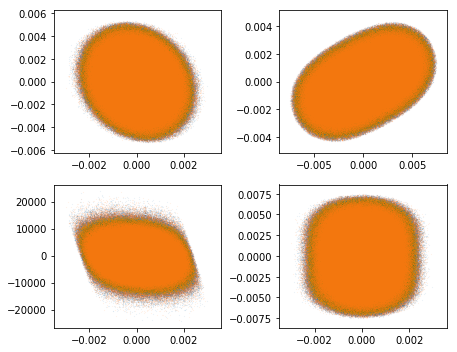

In [25]:
plt.figure(figsize=(6.5,5))
plt.subplot(2,2,1)
plt.scatter(pData1 [:,0],pData1 [:,1],s=0.01,alpha=0.3);
plt.scatter(refData[:,0],refData[:,1],s=0.01,alpha=0.3);
plt.subplot(2,2,2)
plt.scatter(pData1 [:,2],pData1 [:,3],s=0.01,alpha=0.3);
plt.scatter(refData[:,2],refData[:,3],s=0.01,alpha=0.3);
plt.subplot(2,2,3)
plt.scatter(pData1 [:,0],pData1 [:,5],s=0.01,alpha=0.3);
plt.scatter(refData[:,0],refData[:,5],s=0.01,alpha=0.3);
plt.subplot(2,2,4)
plt.scatter(pData1 [:,0],pData1 [:,2],s=0.01,alpha=0.3);
plt.scatter(refData[:,0],refData[:,2],s=0.01,alpha=0.3);
plt.tight_layout()

In [ ]:
diff = refData - pData1
diff[:2,:]

# run

In [ ]:
beam.distribution.distribution_type = 'ReadFile'
impact.writeParticleData(pData1,ke,mass,freq)
import shutil
# shutil.copyfile('partcl.data','partcl.data.atInjection.withEspread.npt=1000000')

In [ ]:
# beam.distribution.alfx = 3.860846841e-5
# beam.distribution.betx = 0.561065822
# beam.distribution.alfy = 2.282987698e-9
# beam.distribution.bety = 1.385141718
# beam.distribution.emitx = emitN
# beam.distribution.emity = emitN
# beam.distribution.betz  = 200
# beam.distribution.alfz  = 0.0
# beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz
# beam.distribution.distribution_type = 'IOTA_Gauss'

# run Impact

In [ ]:
# cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat.insert(0,impact.getElem('loop'))
cleanLat[0].turns = nturn

In [ ]:
cleanLat[2]

In [ ]:
# for i in range(len(cleanLat)):
#     if cleanLat[i].type == 'nonlinear_insert':
#         break
    
# writeP = impact.getElem('write_raw_ptcl')
# writeP.file_id = 1001
# writeP.format_id = 1
# cleanLat.insert(i,copy(writeP))

# writeP.file_id = 1002
# cleanLat.insert(i+2,copy(writeP))


# writeP.file_id = 1003
# cleanLat.append(copy(writeP))

# writeP.file_id = 1000
# cleanLat.insert(2,copy(writeP))

# cleanLat.pop(0)

In [ ]:
# cleanLat = impact.addHardEdgeQuad(cleanLat)
impact.writeInputFile(beam,cleanLat)
impact.run(beam,order=1)

In [ ]:
pData3 = impact.readParticleData(1003,ke,mass,freq,1)

In [ ]:
impact.getTwiss_from_pData(pData1)

In [ ]:
impact.getTwiss_from_pData(pData3)